**Project: Housing Price Prediction**

**Author: Syed Abudahir.A**

**Description: Data loading, cleaning, feature engineering, and ML model.**


IMPORT THE NECESSARY LIBRARIES

In [353]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


READ THE CSV FILE

In [354]:
data= pd.read_csv('bengaluru_house_prices.csv')
# data.head()
data.shape

(13320, 9)

In [355]:
data = data.drop(columns=['area_type', 'society', 'balcony', 'availability'])

data = data.dropna()

data.isnull().sum()

data.shape

(13246, 5)

In [356]:
data1=data.copy()
data1['BHK']= data1['size'].apply(lambda x: int(x.split()[0]))

data1['BHK'].unique() 

# data1.drop(columns=['size'], inplace=True)    
data1.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [357]:
def is_float(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

data1[~data1['total_sqft'].apply(is_float)].head(10)


,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [358]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None
# convert_sqft_to_num("2100 - 2850")

In [359]:
data2= data1.copy()
data2['total_sqft'] = data2['total_sqft'].apply(convert_sqft_to_num)
data2.head(10)
# data2.loc[410]

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
5,Whitefield,2 BHK,1170.0,2.0,38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,370.00,6


In [360]:
data3=data2.copy()
data3['per_sqft'] = data3['price']*100000 / data3['total_sqft']

# len(data3.location.unique())

data3['location'] = data3['location'].apply(lambda x: x.strip())
location_stats = data3['location'].value_counts()
location_stats


location
Whitefield                        535
Sarjapur  Road                    392
Electronic City                   304
Kanakpura Road                    266
Thanisandra                       236
                                 ... 
Vasantapura main road               1
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Abshot Layout                       1
Name: count, Length: 1293, dtype: int64

In [361]:
len(location_stats[location_stats<=10])

location_stats_less_than_10 = location_stats[location_stats<=10]
# location_stats_less_than_10

data3['location'] = data3['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(data3.location.unique())

data3.shape

(13246, 7)

In [362]:
data3[~(data3.total_sqft/data3.BHK<300)].head()

,location,size,total_sqft,bath,price,BHK,per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [363]:
data4= data3[~(data3.total_sqft/data3.BHK<300)]
data4.shape

data4.per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: per_sqft, dtype: float64

In [364]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.per_sqft)
        st = np.std(subdf.per_sqft)
        reduced_df = subdf[(subdf.per_sqft>(m-st)) & (subdf.per_sqft<=(m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out
data5 = remove_pps_outliers(data4)

data5.shape

(10241, 7)

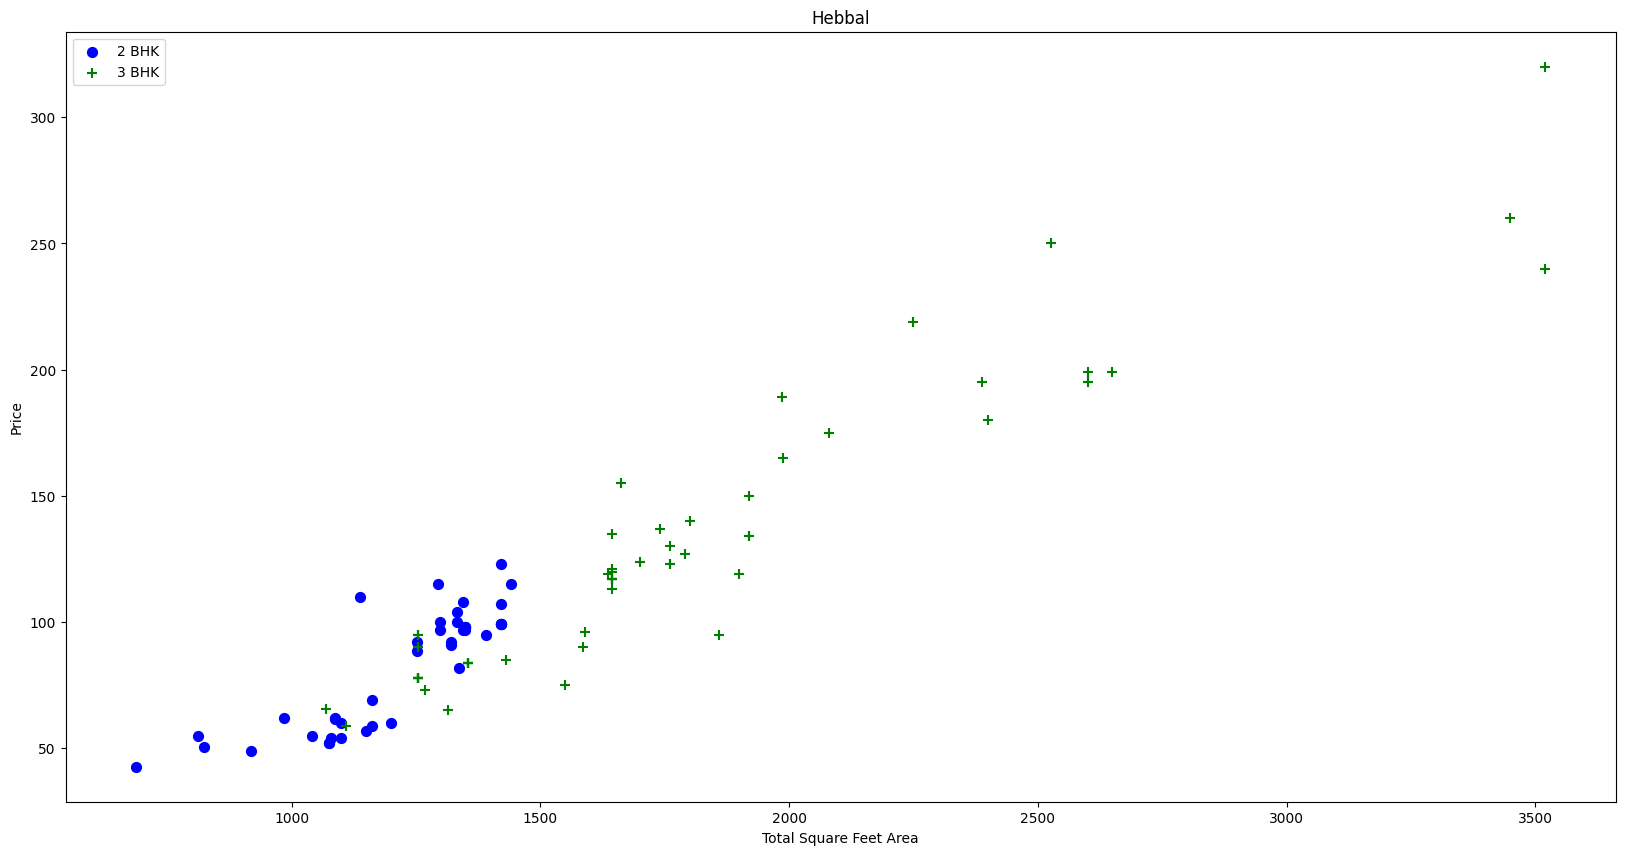

In [365]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.BHK==2)]
    bhk3 = df[(df.location==location) & (df.BHK==3)]
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

plot_scatter_chart(data5, "Hebbal")

In [366]:
def remove_bhk_outliers(df):
   excluded_indices = np.array([])
   for location, location_df in df.groupby('location'):
       bhk_stats = {}
       for bhk, bhk_df in location_df.groupby('BHK'):
           bhk_stats[bhk] = {
               'mean': np.mean(bhk_df.per_sqft),
               'std': np.std(bhk_df.per_sqft),
               'count': bhk_df.shape[0]
           }
       for bhk, bhk_df in location_df.groupby('BHK'):
           stats = bhk_stats.get(bhk-1)
           if stats and stats['count']>5:
               excluded_indices = np.append(excluded_indices, bhk_df[bhk_df.per_sqft < (stats['mean'])].index.values)
   return df.drop(excluded_indices, axis='index')  

data6 = remove_bhk_outliers(data5)

data6.shape

(7329, 7)

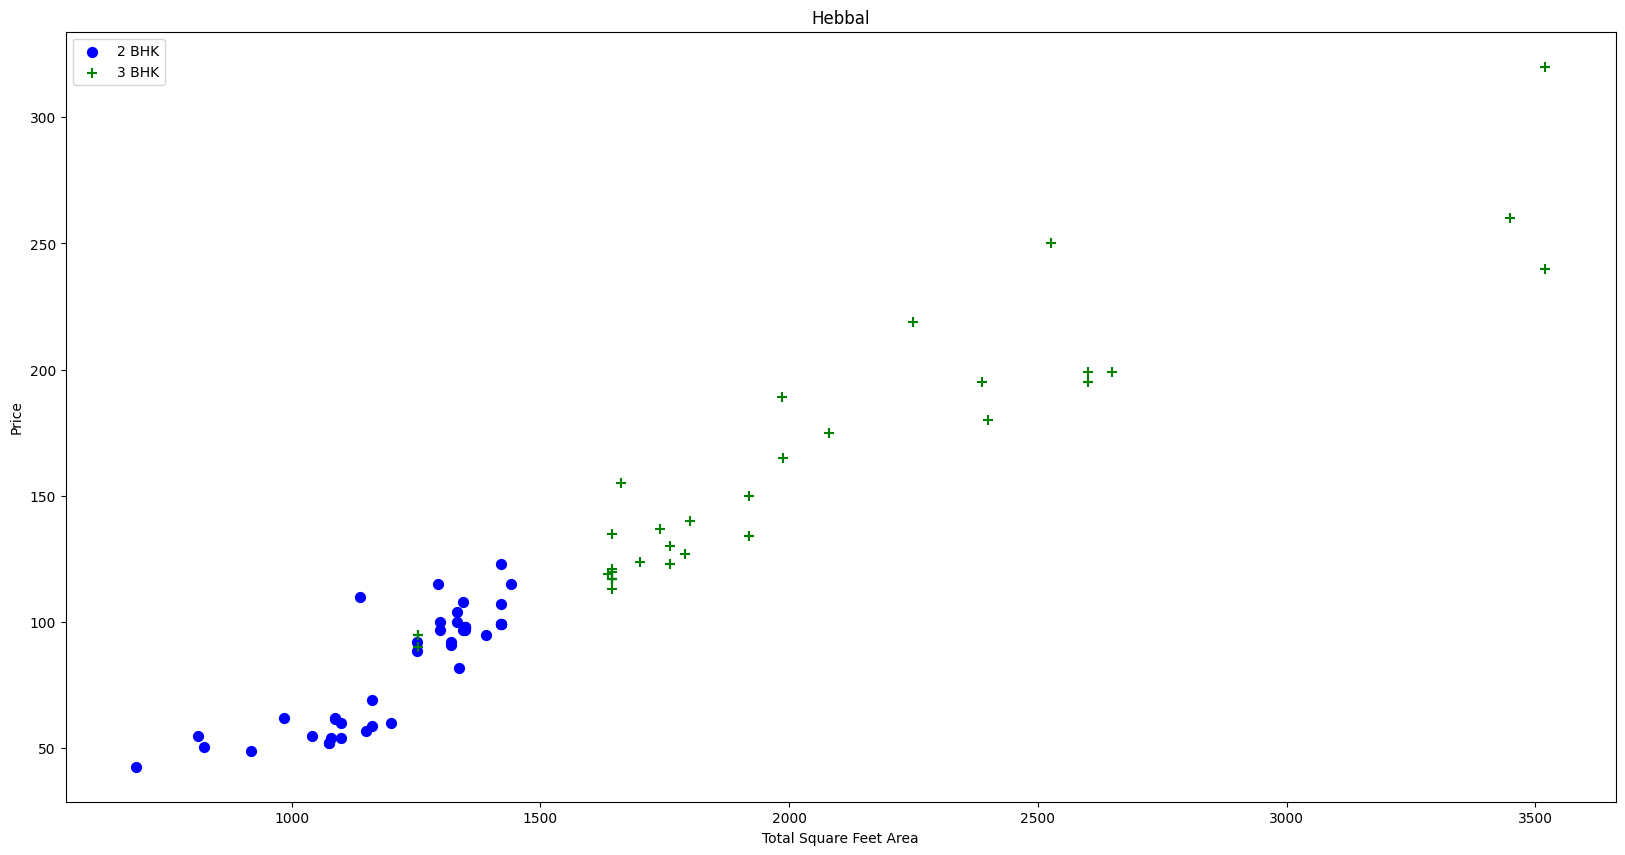

In [367]:
plot_scatter_chart(data6, "Hebbal")

Text(0.5, 1.0, 'Distribution of Price Per Square Feet')

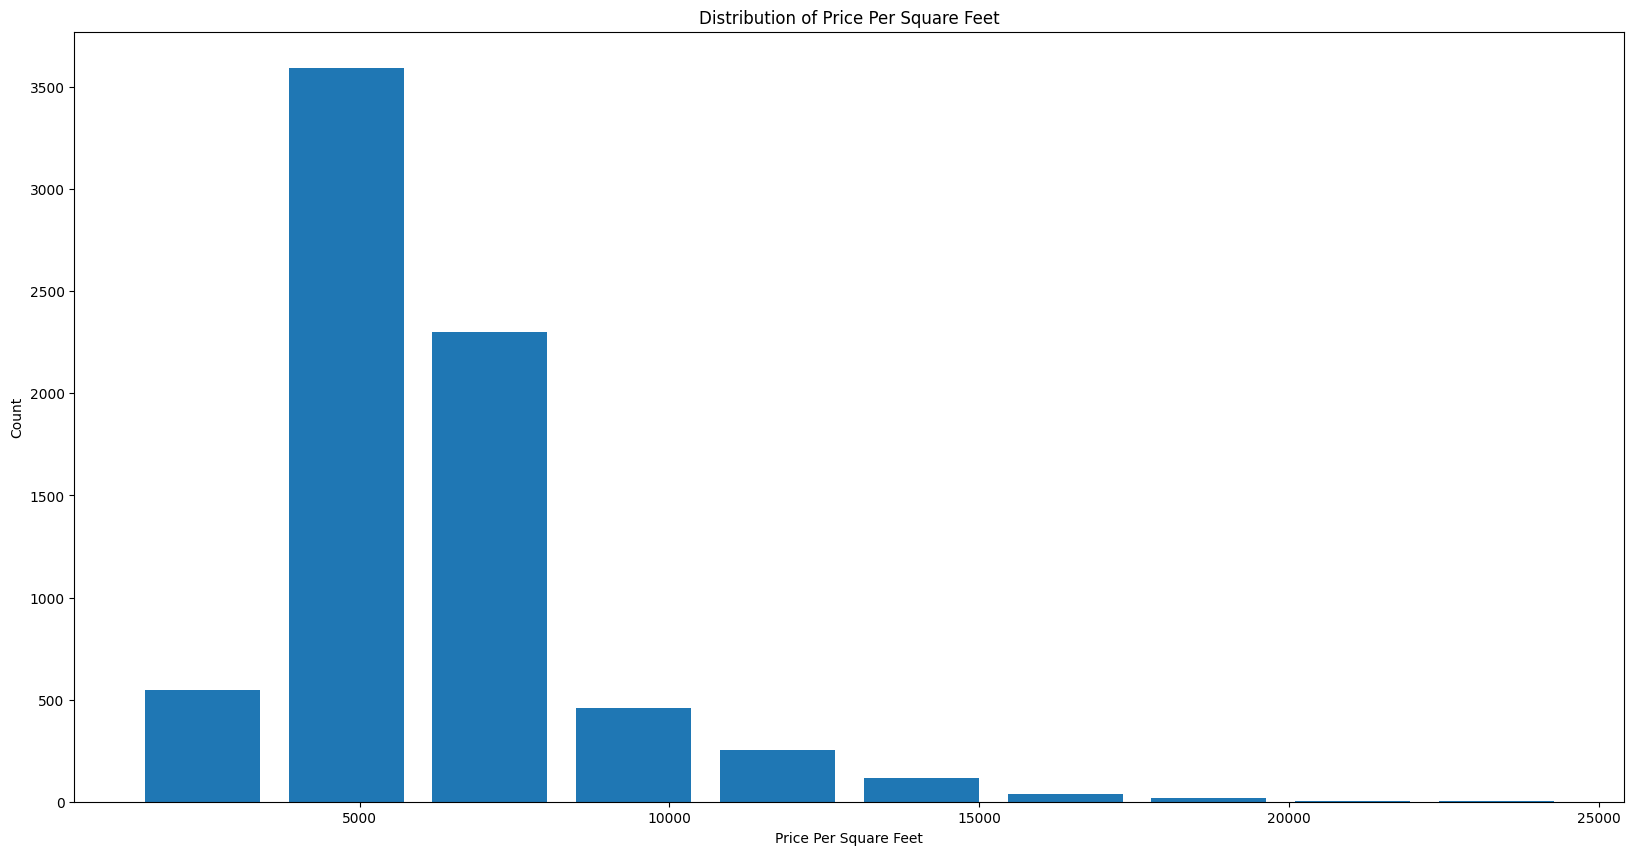

In [368]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10) 
plt.hist(data6.per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.title("Distribution of Price Per Square Feet")

Text(0.5, 1.0, 'Distribution of Number of Bathrooms')

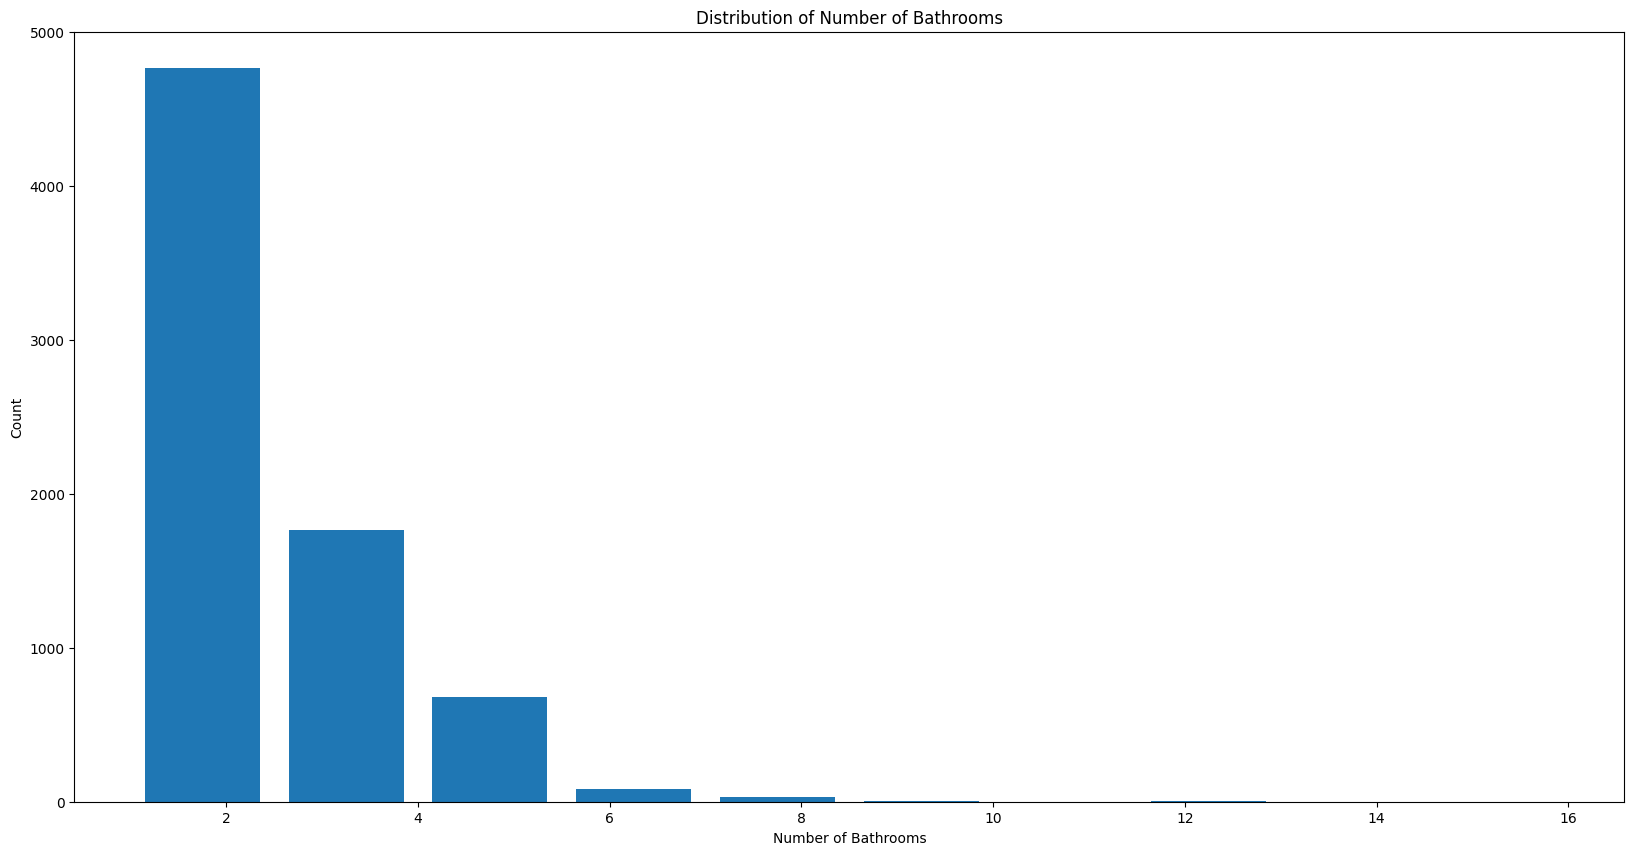

In [369]:
data6.bath.unique()

plt.hist(data6.bath, rwidth=0.8)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")
plt.title("Distribution of Number of Bathrooms")

In [370]:
data6[data6.bath>data6.BHK+2]

,location,size,total_sqft,bath,price,BHK,per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [371]:
data7 = data6[data6.bath<data6.BHK+2]
data7.shape 


(7251, 7)

In [372]:
data8=data7.drop(columns=['size', 'per_sqft'])
data8.head()

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [373]:
pd.get_dummies(data8.location)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10233,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10236,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10237,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [374]:
data9= pd.concat([data8, pd.get_dummies(data8.location).drop(columns=['other'], axis='columns')], axis='columns')
data9.head()

,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [375]:
data10 = data9.drop(columns=['location'], axis='columns')
data10.head()

data10.shape

(7251, 245)

INDEPENDENT VARIABLE 'X' / INPUT


In [376]:
X = data10.drop(columns=['price'], axis='columns')
X.head()


,total_sqft,bath,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


DEPENDENT VARIABLE / OUTPUT

In [377]:
y = data10.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [378]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8746160116851786

In [379]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score 

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [380]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

find_best_model_using_gridsearchcv(X, y)


,model,best_score,best_params
0,linear_regression,0.818354,{}
1,lasso,0.687450,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.718400,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [381]:
# def predict_price(location, sqft, bhk, bath):
#     loc_index = np.where(X.columns == location)[0][0]
#     x = np.zeros(len(X.columns))
#     x[0] = sqft
#     x[1] = bhk
#     x[2] = bath
#     if loc_index >= 0:
#         x[loc_index] = 1
#     return model.predict([x])[0]

In [382]:
def predict_price(location, sqft, bhk, bath):
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bhk
    x[2] = bath
    if location in X.columns:
        loc_index = X.columns.get_loc(location)
        x[loc_index] = 1
    # Convert to DataFrame to match feature names
    x_df = pd.DataFrame([x], columns=X.columns)
    return model.predict(x_df)[0]

In [383]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

93.16334356393476

In [384]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

93.16334356393476

In [385]:
predict_price('Indira Nagar', 1000, 3, 3)

149.2284044750669

In [386]:
import pickle

# Save the trained model to a pickle file
with open('House_price_prediction_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Now load the model from the pickle file
# with open('House_price_prediction_model.pkl', 'rb') as f:
#     model = pickle.load(f)


In [387]:
import json
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))
